# Quality control of data analysis output

When dealing with proteomics data, it is recommended to check the results for inconsistencies and correct application of the data analysis parameters.

We will review the output from two different new tools that generate reports for quality control:

_[PTX-QC](https://cran.r-project.org/web/packages/PTXQC/index.html)_ This is an R package that allows multiple visualizations and metrics for data coming from e.g. MaxQuant or OpenMS workflows. 

_[pmultiqc](https://pypi.org/project/pmultiqc/)_ This Python library is a proteomics plugin for the MultiQC framework that reads output from the [ProteomicsLFQ](https://github.com/nf-core/proteomicslfq) pipeline

### Description of the data

Here, we will check the different visualizations from analyzing a data set that consists of a yeast background with 48 spike-in UPS proteins at different concentrations. 

You can read more about the data set here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4706616/

The data has been fully analyzed with different parameter settings, where I changed the fragment ion tolerance, precursor tolerance or the searched modifications. 

All this data is in the folder _QC_Workshop_.

Each subfolder corresponds to the data from a different data analysis of the same raw data files. The files _multiqc_report.html_ and _results/ptxqc/report....html_ contain the visualization from pmultiqc and PTX-QC.

### Task I: Quality Control

Browse the different reports (html files) and compare the different output between files and across data analyses. 

In order to see the interactive plots, you need to press the button "trust HTML". It might be easier to show the reports in different tabs of your browser (right-click on file and select "Open in New Browser Tab")



#### Add your answers here
(double-click here to edit the cell)

##### Question I:  <ins>When comparing the _Delta Mass_ visualizations of the MultiQC package, do you see any particular trends for the different mass tolerances? How does changing the mass tolerance change this visualization and why?</ins>

_Answer_

##### Question II:  <ins>Which of the analyses provides the largest number of identified mass spectra/peptides/protein groups?</ins>

_Answer_

##### Question III:  <ins>Why are most identified peptides have intensities above 10,000?</ins>

_Answer_

##### Question IV:  <ins>What are miscleavages? How many are found in the data analysis and does it mean when you find many miscleaved peptides?</ins>

_Answer_

##### Question V:  <ins>What most likely happened with the experiment when there are no identifications over a range of the retention time?</ins>

_Answer_

##### Question VI:  <ins>Look at the number of peptides per protein. There is a considerable amount of one-hit-wonders (only one peptide per protein). What does this mean for the identification of a protein?</ins>

_Answer_

##### Question VII:  <ins>Why are most identified peptides have intensities above 10,000?</ins>

_Answer_

##### Question VII:  <ins>Which files have the lowest number of spectra? Why would that be? Check the file names to answer this question.</ins>

_Answer_





### Task II: Quantitative filtering
We now will check the data by our own and investigate how filtering affects the coverage and interpretation.

For each data analysis, there is a _out_msstats.csv_ file in the respective _results/proteomics_lfq/_ folder.

You can now select one of these files by specifying the folder and test how the output changes when changing the different parameters.

#### Read output file and pre-process data
__The calculation in the following cell takes a little while!__

[1] "DONE"


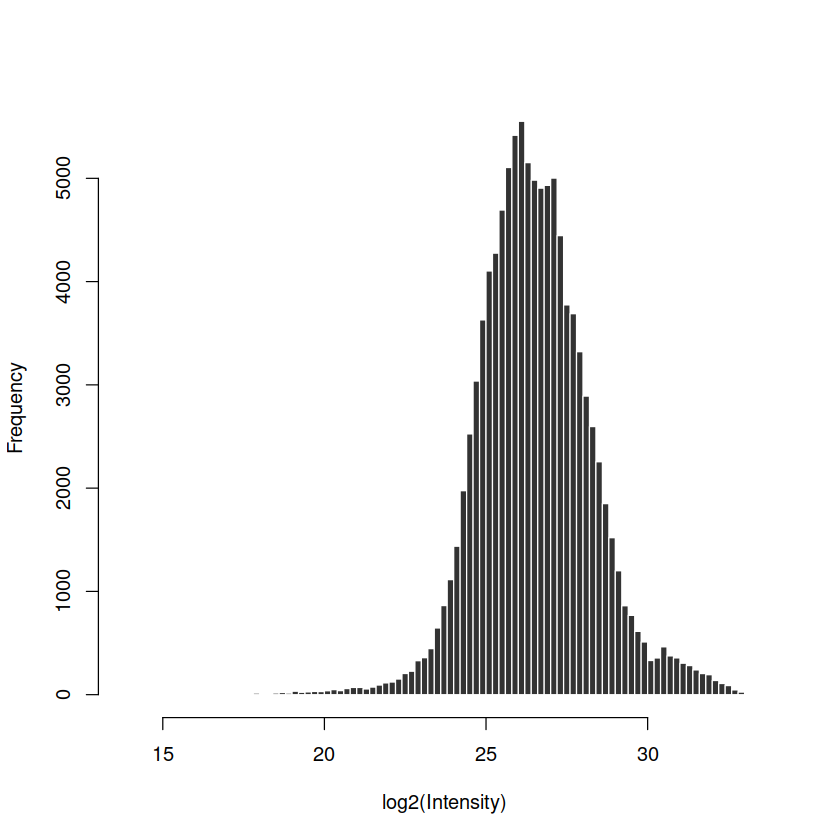

In [47]:
# Change the file path
quant_table <- read.csv("original/results/proteomics_lfq/out_msstats.csv")
# summarize peptides
tpep_table <- by(quant_table, paste0(quant_table$PeptideSequence, quant_table$Run), 
                function(x) c(x[1,c(1,2,7:9,11)], Intensity=sum(x$Intensity,na.rm=T)))
pep_table <- do.call(rbind.data.frame, tpep_table)
                                   
# histogram of intensities
hist(log2(pep_table$Intensity), border=0, col="#333333", xlab="log2(Intensity)", 100, main="")
                                   
print("DONE")
                 



#### Filtering and visualization (identification)

In [220]:
## Filter peptide number per protein
# Change this variable
min_pep <- 5
# filter for number of peptides
pep_table$comb <- paste0(pep_table$ProteinName, pep_table$Run)
filtered_peps <- pep_table[pep_table$comb %in% names(which(table(paste0(pep_table$ProteinName, 
                                                                  pep_table$Run)) > min_pep)),]

## Filter for PTMs
# Use either "none" (none),  "Acetyl" (N-terminal acetylation) or "Oxidation" (Methionine oxidation)
remove_ptm <- "Oxidation"
filtered_peps <- filtered_peps[!grepl(remove_ptm, rownames(filtered_peps)),]

# summary protein groups
tprot_table <- by(filtered_peps, paste0(filtered_peps$ProteinName, filtered_peps$Run), 
                function(x) c(x[1,c(1,3:6)], Intensity = sum(x$Intensity,na.rm=T), Number=length(x$Intensity)))
prot_table <- do.call(rbind.data.frame, tprot_table)





##### Count number of identifications per sample

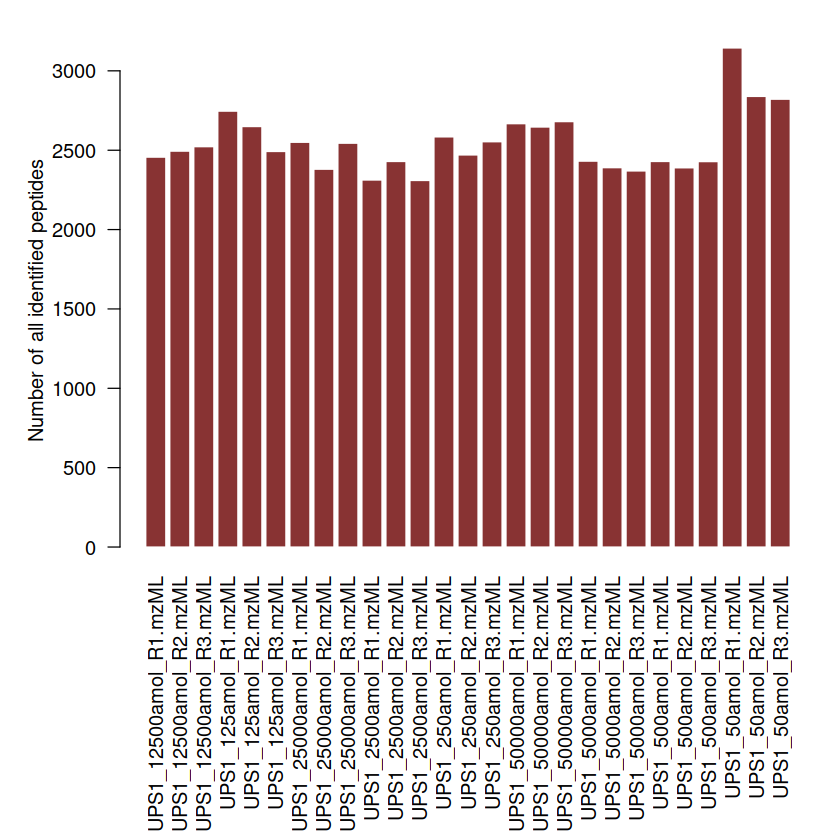

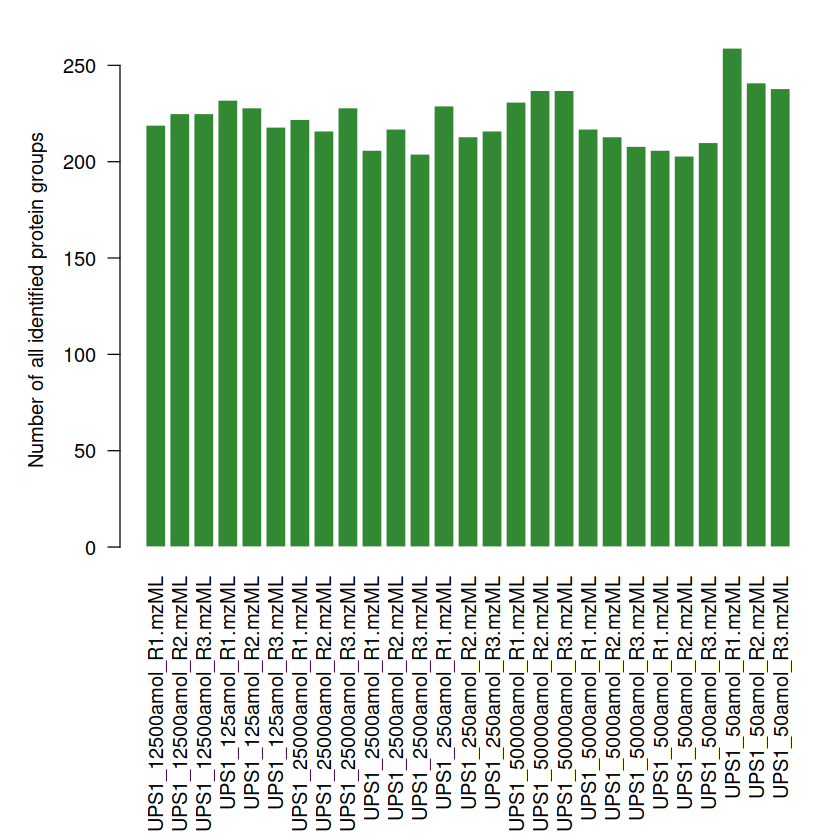

In [221]:
## Plot peptides + proteins per sample
par(mar=c(12,5,2,1))
barplot(unlist(by(filtered_peps, filtered_peps$Reference, nrow)), border=0, col="#883333", 
       las=2, ylab="Number of all identified peptides")                  
barplot(unlist(by(prot_table, prot_table$Reference, nrow)), border=0, col="#338833", 
       las=2, ylab="Number of all identified protein groups")     



Repeat counting for UPS proteins only

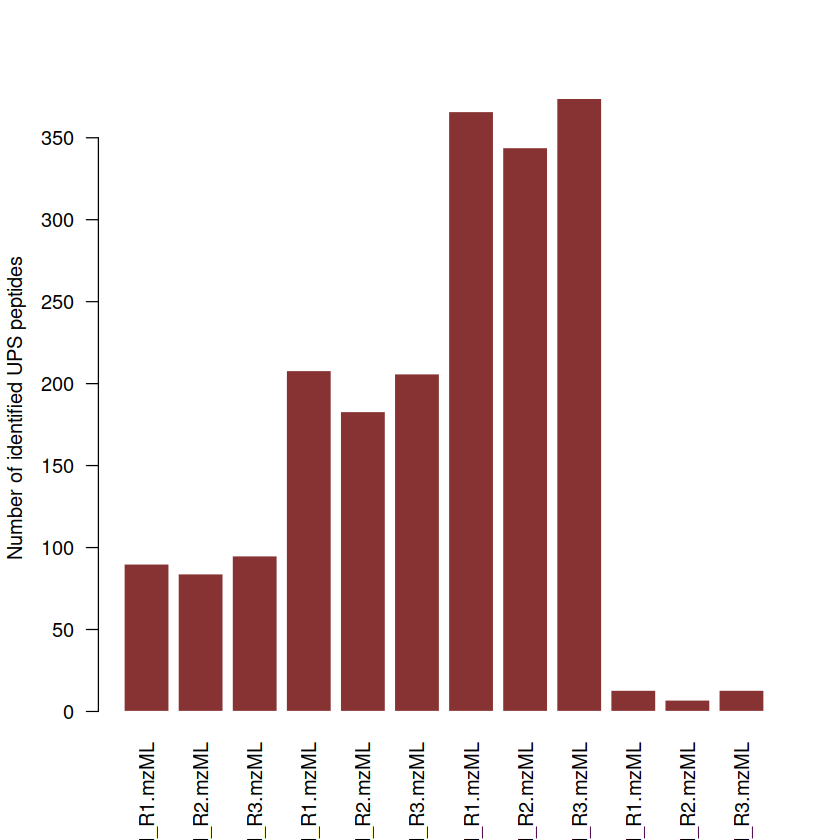

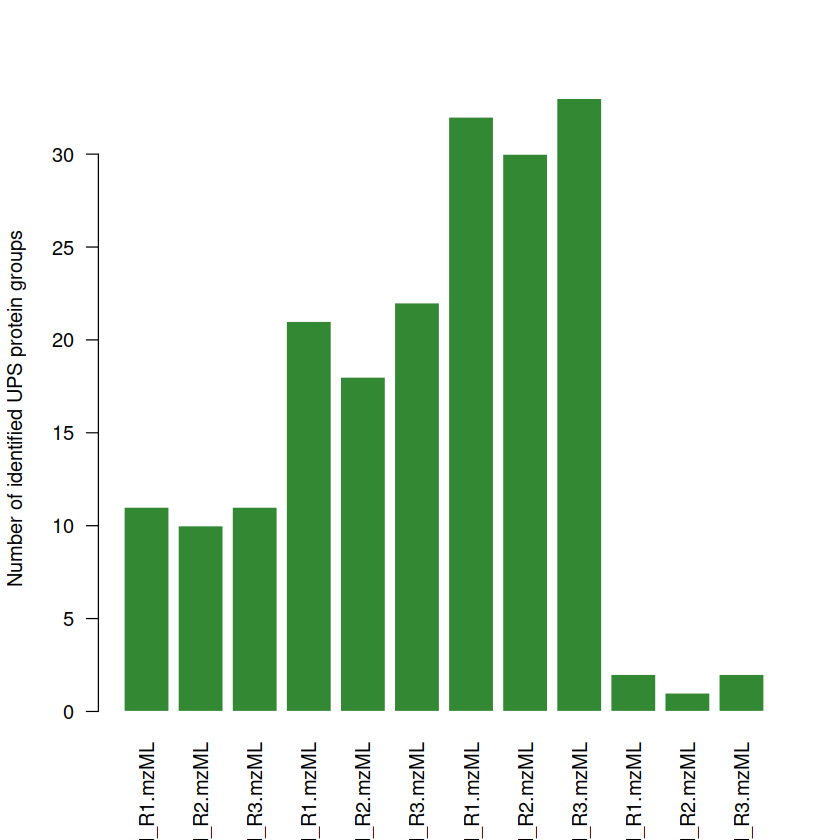

In [222]:
ups_peptides <- filtered_peps[grepl("UPS", filtered_peps$ProteinName),]                  
ups_proteins <- prot_table[grepl("UPS", prot_table$ProteinName),]                  
barplot(unlist(by(ups_peptides, ups_peptides$Reference, nrow)), 
       border=0, col="#883333", 
       las=2, ylab="Number of identified UPS peptides")                  
barplot(unlist(by(ups_proteins, ups_proteins$Reference, nrow)), 
        border=0, col="#338833", las=2, ylab="Number of identified UPS protein groups")                  
par(mar=c(5.1,4.1,4.1,2))                  


#### Visualization (Quantification)

In [223]:
## you might need to install these libraries via "install.packages(c("gplots", "lattice", "matrixStats"))"
library(gplots)
library(lattice)
library(matrixStats)

# Populated matrices with columns as samples
quant_peps <- matrix(NA, dimnames=list(rows=unique(filtered_peps$PeptideSequence), 
                                   cols=unique(filtered_peps$Reference)), 
                    nrow=length(unique(filtered_peps$PeptideSequence)), 
                     ncol=length(unique(filtered_peps$Reference)))
for(i in colnames(quant_peps)) {
    tquant <- filtered_peps[filtered_peps$Reference == i, ]
    quant_peps[tquant$PeptideSequence, i] <- log2(tquant$Intensity)
}

quant_prots <- matrix(NA, dimnames=list(rows=unique(prot_table$ProteinName), 
                                   cols=unique(prot_table$Reference)), 
                    nrow=length(unique(prot_table$ProteinName)), 
                     ncol=length(unique(prot_table$Reference)))
for(i in colnames(quant_prots)) {
    tquant <- prot_table[prot_table$Reference == i, ]
    quant_prots[tquant$ProteinName, i] <- log2(tquant$Intensity)
}



##### Correlations between peptide abundances

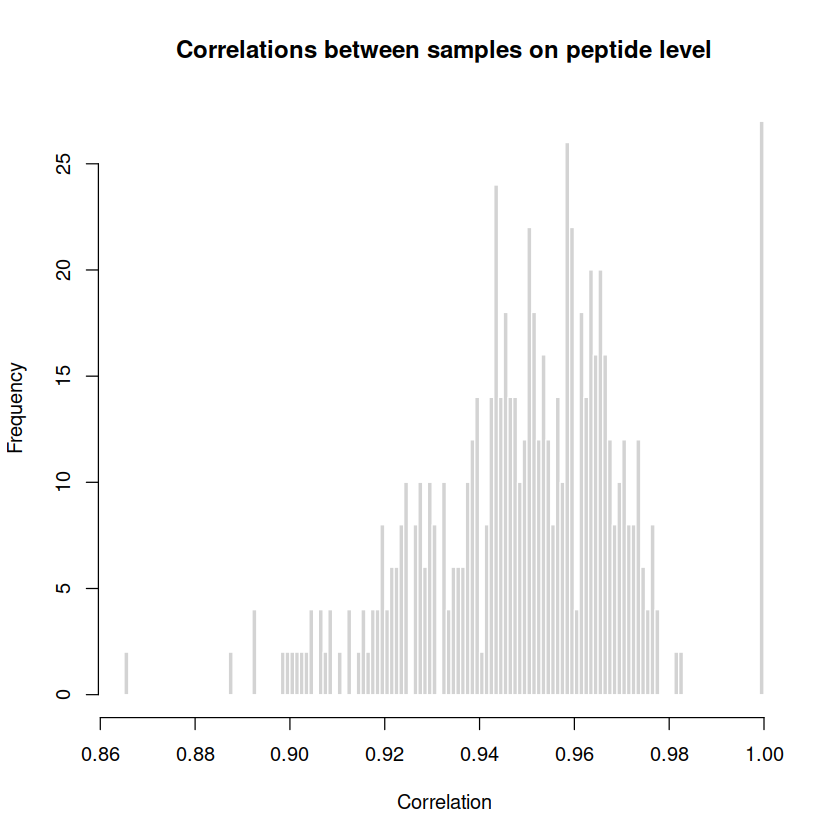

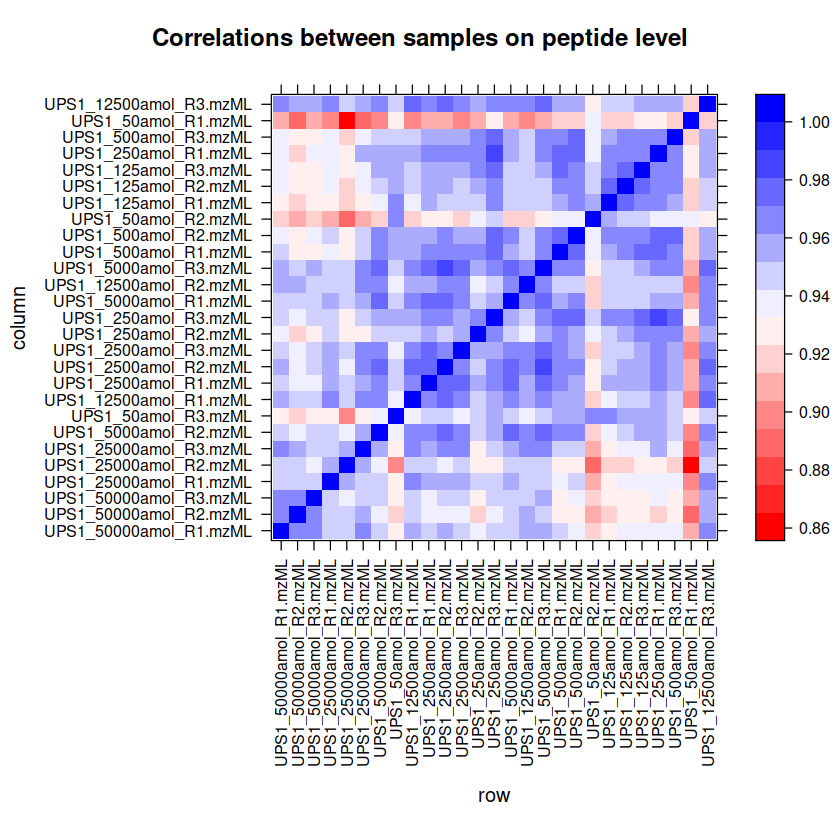

In [224]:
## Correlations on peptide level (how reproducibly are yeast peptides quantified?)
cors <- cor(quant_peps, use="na.or.complete")
hist(cors, main="Correlations between samples on peptide level", 
     100, border=0, xlab="Correlation")
levelplot(cors, col.regions=colorpanel(100, "red","white","blue"), scales=list(x=list(rot=90)),
         main="Correlations between samples on peptide level")





##### Quantitative changes of UPS proteins

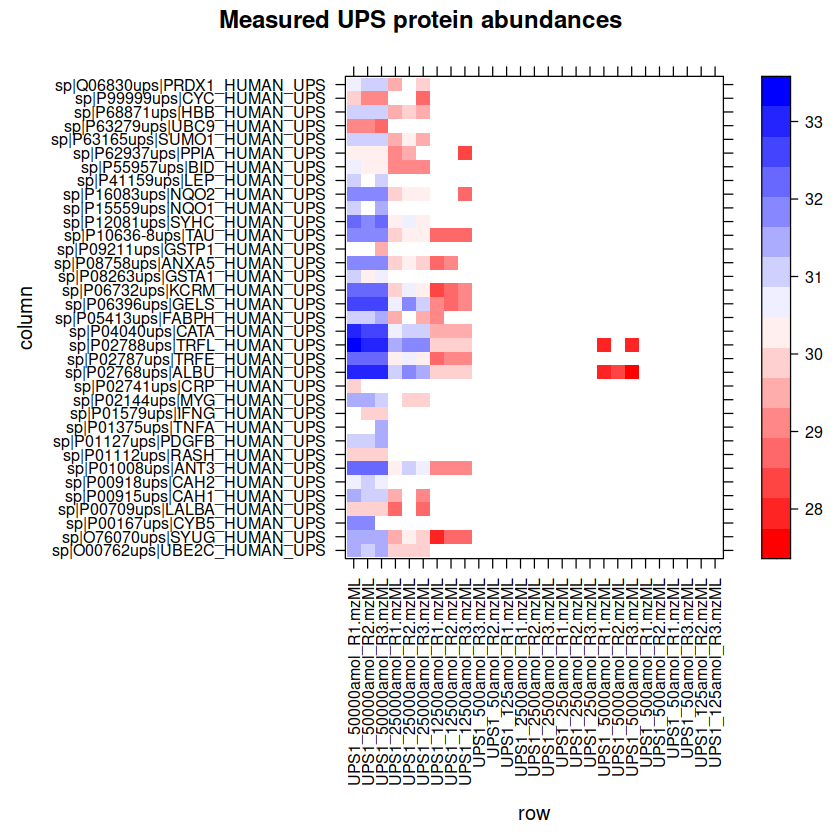

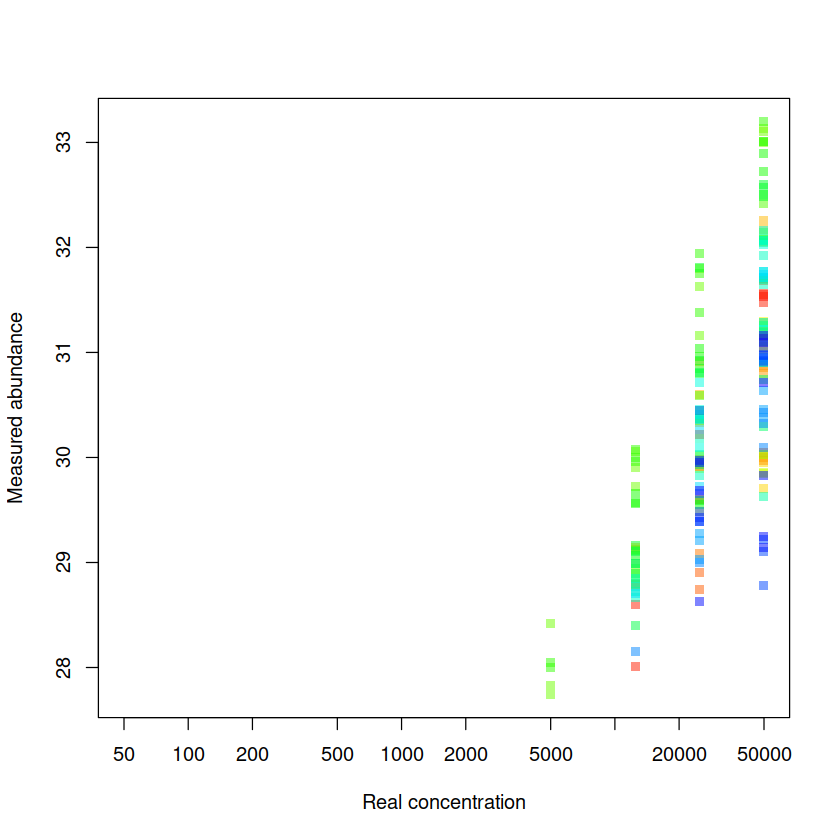

In [225]:
# now only UPS proteins as they change between samples
ups_quant_proteins <- quant_prots[grep("UPS", rownames(quant_prots)),]

levelplot(t(ups_quant_proteins), col.regions=colorpanel(100, "red","white","blue"), scales=list(x=list(rot=90)),
         main="Measured UPS protein abundances")

# comparing to real concentrations
concentrations <- sub("[a-z].*","",unlist(strsplit(colnames(ups_quant_proteins), "_"))
                      [seq(2, ncol(ups_quant_proteins)*3, 3)])
colors <- rainbow(50 ,alpha = 0.5)
plot(concentrations, ups_quant_proteins[1,], type="p", xlab="Real concentration", ylab="Measured abundance",
    log="x", ylim=range(ups_quant_proteins, na.rm=T), pch=15, col=colors[1])
for(i in 2:nrow(ups_quant_proteins)) 
    points(concentrations, ups_quant_proteins[i, ], pch=15, col=colors[i])


#### Add your answers here
(double-click here to edit the cell)

##### Question:  <ins>Why do we now get more idendifications for the "50amol" group?</ins>

_Answer_



[1] "12500" "50000" "50000" "50000" "5000"  "12500" "12500" "25000" "25000"
[10] "25000" "2500"  "2500"  "2500"  "250"   "250"   "250"   "5000"  "5000" 
[19] "500"   "500"   "500"   "50"    "50"    "50"    "125"   "125"   "125"